# Deep Convolutional Generative Adversarial Network - Anime Faces

### Setup

In [1]:
# To generate GIFs
!pip install - q imageio pydot


ERROR: Invalid requirement: '-'


In [2]:
from IPython import display
import time
from IPython.display import Image
from tensorflow.keras import layers
import os
from numpy import asarray
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os.path
import imageio
import glob
from pip._vendor.msgpack.fallback import xrange
import PIL
import PIL.Image

import tensorflow as tf
# Prevent it from printing a bunch of information.
tf.get_logger().setLevel('ERROR')


2022-04-21 16:57:56.057907: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-21 16:57:56.057927: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/media/programming/projects/machineLearning/ML/venv/lib/python3.9/site-packages/_distutils_hack/__init__.py:36: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [3]:
import tensorflow as tf
import zipfile
from io import StringIO, BytesIO  # for Python 3


In [4]:
tf.__version__


'2.8.0'

## Load and process data.
Will take advantage of built in tensorflow/keras for asynchronous load dataset from disk, rather force all data to be loaded in memory.

In [5]:
def load_from_directory(data_dir, image_size, batch_size):
    def configure_for_performance(ds, AUTOTUNE):
        ds = ds.cache()
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds
    # Search and find number of elements within directory, recursively.
    image_count = len(list(data_dir.glob('**/*.??g')))
    print("{0}: Found {1} files".format(data_dir, image_count))

    #
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=True,
        image_size=image_size,
        batch_size=batch_size)
    #
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = tf.keras.layers.Rescaling(1. / 255.0)

    # Translate [0,1] -> [-1, 1]
    normalized_ds = configure_for_performance(train_ds.map(lambda x: normalization_layer(x) * 2.0 - 1.0),
                                              AUTOTUNE)

    return normalized_ds


In [6]:

latent_space_size = 128
BATCH_SIZE = 128
IMAGE_SIZE = (128, 128)
EPOCHS = 50

data_directory_path = "data/"
data_dir = pathlib.Path(data_directory_path)

train_images = load_from_directory(data_dir, IMAGE_SIZE, BATCH_SIZE)

print("Number of batches {0} of {1} elements".format(
    len(train_images), BATCH_SIZE))


data: Found 53840 files
Found 53840 files belonging to 1 classes.
Number of batches 421 of 128 elements


2022-04-21 16:58:12.384588: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-21 16:58:12.384610: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-21 16:58:12.384623: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (enomoto): /proc/driver/nvidia/version does not exist
2022-04-21 16:58:12.384855: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 64x64x3.

In [7]:
def make_generator_model(input_shape):
    init = tf.keras.initializers.RandomNormal(stddev=0.02)

    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*1024, use_bias=False,
              kernel_initializer=init, input_dim=input_shape))
    # model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # model.add(layers.Dense(4*4*1024, use_bias=False,
    #           kernel_initializer=init))
    # model.add(layers.LeakyReLU())

    model.add(layers.Reshape((4, 4, 1024)))
    # Note: None is the batch size
    assert model.output_shape == (None, 4, 4, 1024)

    model.add(layers.Conv2DTranspose(filter=512, kernel_size=(5, 5), strides=(2, 2),
              padding='same', use_bias=False, kernel_initializer=init))
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.BatchNormalization(momentum=0.5))
    # model.add(layers.ReLU())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(filter=256, kernel_size=(5, 5), strides=(2, 2),
              padding='same', use_bias=False, kernel_initializer=init))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization(momentum=0.5))
    # model.add(layers.ReLU())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(filter=128, kernel_size=(5, 5), strides=(2, 2),
              padding='same', use_bias=False, kernel_initializer=init))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization(momentum=0.5))
    # model.add(layers.ReLU())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(filter=64, kernel_size=(5, 5), strides=(2, 2),
              padding='same', use_bias=False, kernel_initializer=init))
    assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization(momentum=0.5))
    # model.add(layers.ReLU())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(
        3, kernel_size=(7, 7), strides=(2, 2), padding='same'))
    model.add(layers.Activation('tanh'))
    assert model.output_shape == (None, 128, 128, 3)

    return model


Use the (as yet untrained) generator to create an image.

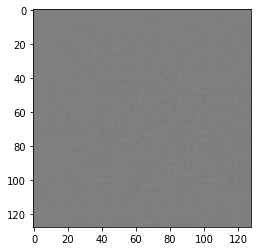

In [8]:

latent_space_c = (latent_space_size)
generator = make_generator_model(latent_space_c)

noise = tf.random.normal([1, latent_space_size])

generated_image = generator(noise, training=False)

# Convert image from [-1,1] to [0,1]
rgb = (generated_image[0, :, :, 0:3] + 1.0) / 2.0

plt.imshow(asarray(rgb))


### The Discriminator

The discriminator is a CNN-based image classifier.

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', use_bias=False,
                            input_shape=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(filter=128, kernel=(5, 5), strides=(
        2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(filter=256, kernel=(5, 5), strides=(
        2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(filter=512, kernel=(5, 5), strides=(
        2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(filter=512, kernel=(5, 5), strides=(
        2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(filter=1, kernel_size=4, strides=1,
              padding='valid', use_bias=False))
    model.add(layers.Flatten())
    #model.add(layers.Dropout(0.3))
    model.add(layers.Activation('sigmoid'))

    return model


Example of using the discriminator for determine if a image is real. However, since either model are trained, the result will not be useful.

In [10]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)


tf.Tensor([[0.49978054]], shape=(1, 1), dtype=float32)


In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)


In [12]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [13]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [14]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


## Generator Model

In [15]:

# tf.keras.utils.plot_model(
#     generator, to_file='generator_model.png', show_shapes=True, show_dtype=True,
#     show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
#     layer_range=None
# )
generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             2097152   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 512)        13107200  
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 512)        2048      
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 512)         0

## Discriminator Model

In [16]:

# tf.keras.utils.plot_model(
#     discriminator, to_file='discriminator_model.png', show_shapes=True, show_dtype=True,
#     show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
#     layer_range=None
# )
discriminator.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1728      
                                                                 
 batch_normalization_4 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       204800    
                                                                 
 batch_normalization_5 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 128)      

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [17]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [18]:
def generate_grid_image(model, latent_space, figsize=(8, 8), subplotsize=(3, 3)):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(latent_space, training=False)

    fig = plt.figure(figsize=figsize)
    for i in range(predictions.shape[0]):
        plt.subplot(subplotsize[0], subplotsize[1], i + 1)
        rgb = (predictions[i, :, :, 0:3] + 1.0) / 2.0
        plt.imshow(asarray(rgb))
        plt.axis('off')
    plt.close()
    return fig


def generate_and_save_images(model, epoch, test_input):
    fig = generate_grid_image(model, test_input)
    fig.savefig('image_at_epoch_{:04d}.png'.format(epoch), transparent=False)
    plt.show()


In [19]:
# Generate a big image.
def generateBigBridImage(model, grid_size):
    width, height = grid_size

    noise = tf.random.normal([1, latent_space_size])
    noise = tf.random.normal([width * height, latent_space_size])

    generated_images = model(noise, training=False)

    fig = plt.figure(figsize=(width * 2, height * 2))
    for i in range(generated_images.shape[0]):
        plt.subplot(height, width, i+1,)

        plt.imshow(((generated_images[i, :, :, :] + 1.0) / 2.0), aspect='auto')
        plt.axis("off")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.close()
    return fig


2022-04-21 16:58:15.201244: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


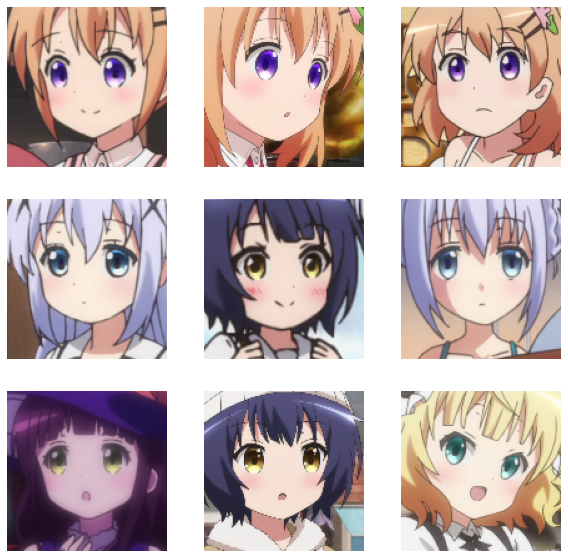

In [20]:
num_examples_to_generate = 9

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, latent_space_size])

plt.figure(figsize=(10, 10))
for images in train_images.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # Transform pixel values from [-1,1] to [0,1]
        plt.imshow((images[i].numpy() + 1.0) / 2.0)
        plt.axis("off")
plt.show()


In [21]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, latent_space_size])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss


In [22]:
def train(dataset, epochs):

    for epoch in range(epochs):
        start = time.time()

        for i, image_batch in enumerate(train_images):
            batch_start_time = time.time()
            gen_loss, disc_loss = train_step(image_batch)
            batch_elapse_time = (time.time() - batch_start_time)
            estimate_time = batch_elapse_time * (len(train_images) - i)
            print("epoch {0} processed {1}/{2} - gen-loss: {3}, dis-loss {4} {5} sec | estimate {6} sec left".format(epoch, i * len(
                train_images),
                len(train_images) * len(
                train_images),
                gen_loss, disc_loss,
                batch_elapse_time,
                estimate_time),
                end='\r')
        print("\n\n")

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)
        grid_size = (16, 9)
        big_fig = generateBigBridImage(generator, grid_size)
        big_fig.savefig('big_image_at_epoch_{:04d}.png'.format(
            epoch + 1), transparent=None)
        # Save the model every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {} sec'.format(
            epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epochs,
                             seed)


In [23]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [24]:
train(train_images, EPOCHS)


Time for epoch 50 is 4290.5127074718475 sec


In [25]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))


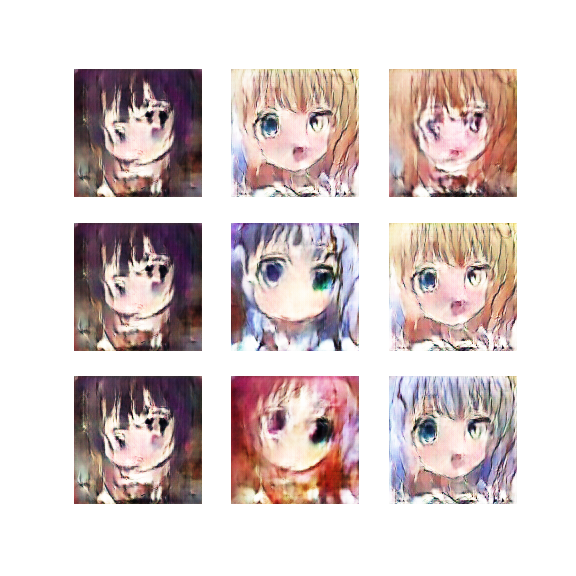

In [26]:
display_image(EPOCHS)


## Save Final Models

In [27]:
generator_model_filepath = "dcgan-anime-generator.h5"
generator.save("dcgan-anime-generator.h5")
discriminator.save("dcgan-anime-discriminator.h5")


## Load Model and Generator Results

In [1]:
generator = tf.keras.models.load_model(generator_model_filepath)


NameError: name 'tf' is not defined

In [2]:
grid_size = (14, 6)
generateBigBridImage(generator, grid_size)
plt.show()


NameError: name 'generateBigBridImage' is not defined

## Create a GIF


Use `imageio` to create an animated gif using the images saved during training.

In [30]:
anim_file = 'anime-dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


Image(url=anim_file)


## Generate Transition Image

By adjusting between two points within the latent space and interpolated.

In [31]:
def interpolate(zs, steps):
    out = []
    for i in range(len(zs)-1):
        for index in range(steps):
            fraction = index/float(steps)
            out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
    return out


In [32]:
import scipy
import moviepy.editor


In [33]:

fps = 15
duration_sec = 5
smoothing_sec = 1.0
num_frames = 4 * fps

shape = [num_frames, np.prod(latent_space_size)]

nr_elemenets = 9

seeds = np.random.randint(10000, size=2)
zs = [tf.random.normal([nr_elemenets, latent_space_size], seed=s)
      for s in seeds]

all_latents = interpolate(zs, num_frames)


def make_frame(t):
    frame_idx = int(np.clip(np.round(t * fps), 0, num_frames - 1))
    latents = all_latents[frame_idx]

    #
    fig = generate_grid_image(generator, latents, (5, 5), (3, 3))

    #
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return data


gif_filepath = ('transition_grid_{0}.gif'.format(seeds[0]))
video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)
video_clip.write_gif(gif_filepath, fps=fps)


MoviePy - Building file transition_grid_6318.gif with imageio.


In [34]:
Image(url=gif_filepath)
